# Include Chirp In Training - testing for 6000

In [1]:
from tensorflow import keras
import numpy as np
from sklearn.metrics import confusion_matrix
from collections import Counter
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from scipy.signal import chirp

In [2]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, cbar = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    if cbar == True:
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
model = keras.models.load_model("/Volumes/KleeFD/models/Chirp/train with chirp-one model one output _ re-preprocessed data.h5")

In [4]:
# model = keras.models.load_model("/Volumes/KleeFD/models/Testing effect of window size/one thirds/iter 1.h5")

In [5]:
categories = []

boa_cat = [25.0]*8 + [30.0]*8
freq_cat = [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]

for b, f in zip(boa_cat, freq_cat):
    categories.append((str(b) + ', '+ str(f)))

# Convert plt -> npy

In [ ]:
def velfield(ts, boa):
    
    path = '/Volumes/KleeFD/ibpm raw data/klee-chirp_BoA'+str(boa)+'_f0p05f0p5_L06000/ibpm'\
                + str(format(ts, '05'))+'.plt'
    with open(path) as file:
        f_text = file.read()

    f_list = f_text[191:]
    f_list = f_list.split(' ')
    f_list.pop()

    UX, UY = [], []
    for idx, val in enumerate(f_list):
        if val[0] == '\n':
            UX.append(float(f_list[idx+2]))
            UY.append(float(f_list[idx+3]))
    UX = np.array(UX); UY = np.array(UY)

    UX = UX.reshape(299, 599)
    UY = UY.reshape(299, 599)

    return UX, UY

In [ ]:
# This is how timestep, freq, angle is defined

ibpm_time = np.arange(5510, 11500, 10)
freq = 0.05 + ((ibpm_time - 5501)/100)/60*(0.5-0.05)

ori_time = np.arange(0, 60, 0.01)

angle = 5*chirp(ori_time, 0.05, 30, 0.5, method = 'linear', phi = 0)
angle = angle[9::10][:-1]

In [ ]:
mean = np.load("/Volumes/KleeFD/dataset/dataset_chirp/04_sinusoidal + chirp _repreprocessed/mean.npy")
ux_range = np.load("/Volumes/KleeFD/dataset/dataset_chirp/04_sinusoidal + chirp _repreprocessed/ux_range.npy")
uy_range = np.load("/Volumes/KleeFD/dataset/dataset_chirp/04_sinusoidal + chirp _repreprocessed/uy_range.npy")

In [ ]:
chirp_X25 = np.zeros((len(ibpm_time), 200, 200))

for i, timestep in enumerate(ibpm_time):
    
    UX, UY = velfield(timestep, 25)
    
    UX = UX[99:199, 399:599]/ux_range
    UY = UY[99:199, 399:599]/uy_range
    
    chirp_X25[i] = np.concatenate((UX, UY))
    chirp_X25[i] -= mean
    
chirp_X25 = chirp_X25.reshape(len(ibpm_time), 200, 200,1)

# Categorize the continuous frequency

freq_cat = np.array([0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6])

# Set threshold values to be the mean value between two categoires. i.e. if 0.075 < x < 0.15 then 0.1
thres = []
for i in range(8):
    thres.append(tuple([(freq_cat[i+1] + freq_cat[i])/2, (freq_cat[i+1] + freq_cat[i+2])/2]))

freq_cat = np.array([0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5])

freq = 0.05 + ((ibpm_time - 5501)/100)/60*(0.5-0.05)

categorized_freq = []
for i, f in enumerate(freq):
    for cat_num in range(8):
        bound = thres[cat_num]
        if bound[0] < f and bound[1] > f:
            categorized_freq.append(freq_cat[cat_num])
            
categorized_freq = np.array(categorized_freq)
boa = (np.full((len(ibpm_time), 1), 25.0)).reshape(-1,1)
typ = (np.full((len(ibpm_time), 1), 'chirp')).reshape(-1,1)
inst_angle = (25 - angle).reshape(-1,1)
inst_freq = freq.reshape(-1,1)

chirp_Y25 = np.column_stack((boa, categorized_freq, typ, inst_angle, inst_freq))

In [ ]:
chirp_X30 = np.zeros((len(ibpm_time), 200, 200))

for i, timestep in enumerate(ibpm_time):
    
    UX, UY = velfield(timestep, 30)
    
    UX = UX[99:199, 399:599]/ux_range
    UY = UY[99:199, 399:599]/uy_range
    
    chirp_X30[i] = np.concatenate((UX, UY))
    chirp_X30[i] -= mean
    
chirp_X30 = chirp_X30.reshape(len(ibpm_time), 200, 200,1)

# Categorize the continuous frequency

freq_cat = np.array([0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6])

# Set threshold values to be the mean value between two categoires. i.e. if 0.075 < x < 0.15 then 0.1
thres = []
for i in range(8):
    thres.append(tuple([(freq_cat[i+1] + freq_cat[i])/2, (freq_cat[i+1] + freq_cat[i+2])/2]))

freq_cat = np.array([0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5])

freq = 0.05 + ((ibpm_time - 5501)/100)/60*(0.5-0.05)

categorized_freq = []
for i, f in enumerate(freq):
    for cat_num in range(8):
        bound = thres[cat_num]
        if bound[0] < f and bound[1] > f:
            categorized_freq.append(freq_cat[cat_num])
            
categorized_freq = np.array(categorized_freq)
boa = (np.full((len(ibpm_time), 1), 30.0)).reshape(-1,1)
typ = (np.full((len(ibpm_time), 1), 'chirp')).reshape(-1,1)
inst_angle = (30 - angle).reshape(-1,1)
inst_freq = freq.reshape(-1,1)

chirp_Y30 = np.column_stack((boa, categorized_freq, typ, inst_angle, inst_freq))

In [9]:
Y = np.zeros((len(chirp_Y25), 1), dtype = '<U10')
for i in range(len(chirp_Y25)):
    Y[i] = (str(chirp_Y25[i,0])+', '+ str(chirp_Y25[i, 1]))
chirp_Y25 = Y

Y = np.zeros((len(chirp_Y30), 1), dtype = '<U10')
for i in range(len(chirp_Y30)):
    Y[i] = (str(chirp_Y30[i,0])+', '+ str(chirp_Y30[i, 1]))
chirp_Y30 = Y

In [ ]:
chirp_X = np.concatenate((chirp_X25, chirp_X30), axis = 0)
chirp_Y = np.concatenate((chirp_Y25, chirp_Y30), axis = 0)

# Chirp Evaluation

In [10]:
pred_proba = model.predict(chirp_X)

9/9 [==============================] - 1s 40ms/step


In [11]:
pred_idx = np.argmax(pred_proba, axis = 1)
pred = []

for p in pred_idx:
    pred.append(categories[p])

print(classification_report(chirp_Y, pred))

              precision    recall  f1-score   support

  25.0, 0.05       1.00      0.86      0.92         7
   25.0, 0.1       0.96      1.00      0.98        22
   25.0, 0.2       1.00      1.00      1.00        23
  25.0, 0.25       1.00      0.73      0.85        15
   25.0, 0.3       0.78      0.93      0.85        15
  25.0, 0.35       0.87      0.87      0.87        15
   25.0, 0.4       0.92      0.96      0.94        23
   25.0, 0.5       0.94      1.00      0.97        15
  30.0, 0.05       0.39      1.00      0.56         7
   30.0, 0.1       1.00      0.45      0.62        22
   30.0, 0.2       1.00      1.00      1.00        23
  30.0, 0.25       1.00      1.00      1.00        15
   30.0, 0.3       1.00      0.60      0.75        15
  30.0, 0.35       1.00      0.07      0.12        15
   30.0, 0.4       0.41      0.52      0.46        23
   30.0, 0.5       0.28      0.53      0.36        15

    accuracy                           0.78       270
   macro avg       0.85   

Confusion matrix, without normalization


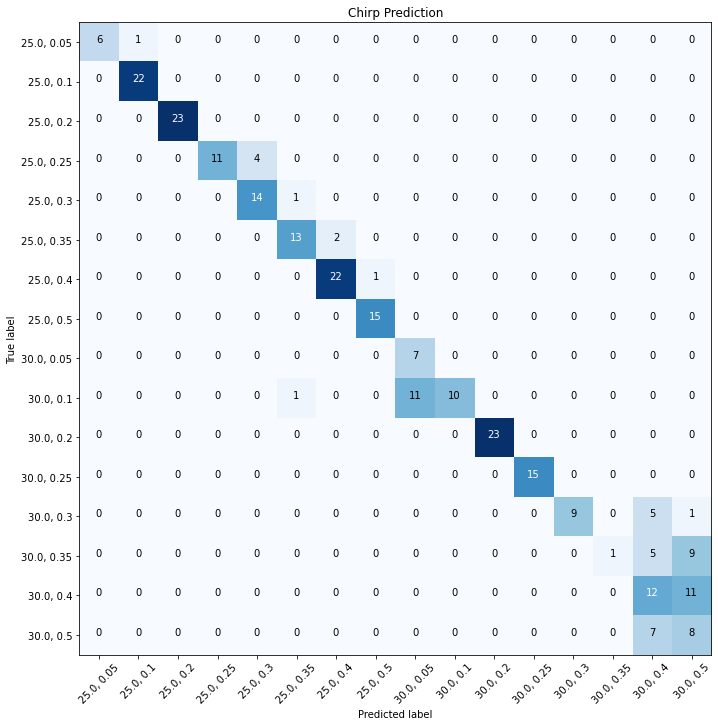

In [12]:
cnf_matrix = confusion_matrix(chirp_Y, pred)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes = categories, normalize=False,
                      title='Chirp Prediction')
plt.show()

# In depth investigation for chirp

1. check for freq - boa separately
1. check instantaneous angle of attack & frequency for incorrect cases

In [13]:
boa_pred = []; freq_pred = []
for p in pred:
    boa_pred.append(p.split(', ')[0])
    freq_pred.append(p.split(', ')[1])

boa_pred = np.array(boa_pred); freq_pred = np.array(freq_pred)

In [14]:
boa = []; freq = []
for p in chirp_Y[:,:2]:
    p = p[0]
    boa.append(p.split(', ')[0])
    freq.append(p.split(', ')[1])

boa = np.array(boa); freq = np.array(freq)

In [15]:
print("BoA")
print(classification_report(boa, boa_pred))
print('='*50)
print("freq")
print(classification_report(freq, freq_pred))

BoA
              precision    recall  f1-score   support

        25.0       0.99      1.00      1.00       135
        30.0       1.00      0.99      1.00       135

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270

freq
              precision    recall  f1-score   support

        0.05       0.54      0.93      0.68        14
         0.1       0.97      0.73      0.83        44
         0.2       1.00      1.00      1.00        46
        0.25       1.00      0.87      0.93        30
         0.3       0.85      0.77      0.81        30
        0.35       0.88      0.47      0.61        30
         0.4       0.64      0.74      0.69        46
         0.5       0.51      0.77      0.61        30

    accuracy                           0.78       270
   macro avg       0.80      0.78      0.77       270
weighted avg       0.83      0.78      0.79       270



Confusion matrix, without normalization


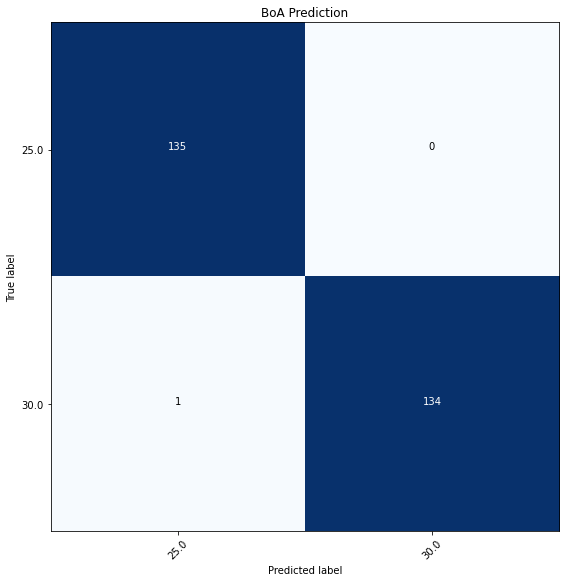

Confusion matrix, without normalization


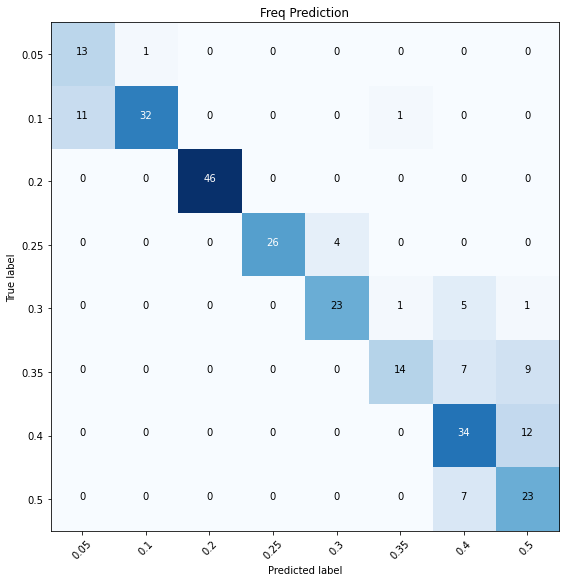

In [16]:
cnf_matrix1 = confusion_matrix(boa, boa_pred)
cnf_matrix2 = confusion_matrix(freq, freq_pred)

plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix1, classes = ['25.0', '30.0'], normalize=False,
                      title='BoA Prediction')
plt.show()

plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix2, classes = [str(f) for f in freq_cat[0:8]], normalize=False,
                      title='Freq Prediction')
plt.show()

## checking instantaneous angle & frequency for incorrect cases

In [17]:
chirp_Y = test_Y[chirp]
sin_Y = test_Y[sin]

chirp_X = test_X[chirp]
sin_X = test_X[sin]

In [18]:
data = {}
for cat in freq_cat[0:8]:
    print("frequency :", cat)
    f_indices = np.where(freq == str(cat))[0].reshape(-1)

    wrong_indices = []
    for idx in f_indices:
        if freq_pred[idx] != freq[idx]:
            wrong_indices.append(idx)
    wrong_indices = np.array(wrong_indices).reshape(-1)
    data[float(cat)] = wrong_indices
    
    for wi in wrong_indices:
        print("freq_pred : {:.2f}, inst_angle : {:.3f}, inst_freq : {:.3f}".format(float(freq_pred[wi]),float(chirp_Y[wi][3]), float(chirp_Y[wi][4])))
    print("=" * 40)

frequency : 0.05
freq_pred : 0.10, inst_angle : 28.045, inst_freq : 0.074
frequency : 0.1
freq_pred : 0.05, inst_angle : 26.030, inst_freq : 0.096
freq_pred : 0.05, inst_angle : 34.940, inst_freq : 0.114
freq_pred : 0.05, inst_angle : 34.945, inst_freq : 0.082
freq_pred : 0.05, inst_angle : 33.125, inst_freq : 0.087
freq_pred : 0.05, inst_angle : 31.586, inst_freq : 0.109
freq_pred : 0.05, inst_angle : 26.752, inst_freq : 0.104
freq_pred : 0.05, inst_angle : 35.000, inst_freq : 0.081
freq_pred : 0.05, inst_angle : 28.502, inst_freq : 0.093
freq_pred : 0.05, inst_angle : 34.787, inst_freq : 0.083
freq_pred : 0.35, inst_angle : 25.096, inst_freq : 0.099
freq_pred : 0.05, inst_angle : 34.985, inst_freq : 0.081
freq_pred : 0.05, inst_angle : 34.778, inst_freq : 0.116
frequency : 0.2
frequency : 0.25
freq_pred : 0.30, inst_angle : 24.078, inst_freq : 0.273
freq_pred : 0.30, inst_angle : 25.634, inst_freq : 0.274
freq_pred : 0.30, inst_angle : 28.423, inst_freq : 0.275
freq_pred : 0.30, inst

In [19]:
data # contains wrong indices

{0.05: array([124]),
 0.1: array([135, 158, 164, 165, 177, 186, 199, 213, 216, 227, 241, 249]),
 0.2: array([], dtype=float64),
 0.25: array([  7,  60,  67, 125]),
 0.3: array([ 89, 144, 193, 198, 223, 224, 263]),
 0.35: array([ 50,  61, 148, 160, 168, 172, 185, 196, 197, 220, 229, 231, 239,
        240, 254, 269]),
 0.4: array([ 32, 139, 140, 145, 149, 162, 166, 189, 208, 222, 225, 232]),
 0.5: array([151, 155, 173, 184, 243, 255, 264])}